In [49]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift
from scipy.signal import correlate2d
%matplotlib inline

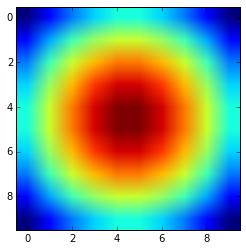

In [4]:
x, y = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))
d = np.sqrt(x*x+y*y)
sigma, mu = 1.0, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

plt.imshow(g)

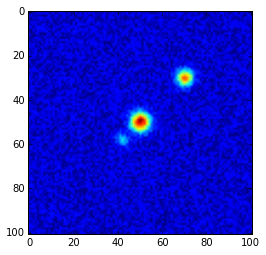

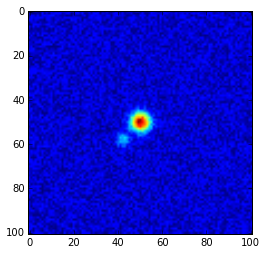

In [46]:
gauss = Gaussian2D(10, 0, 0, 3, 3)
gauss2 = Gaussian2D(8, 20, -20, 2.5, 2.5)
gauss3 = Gaussian2D(3, -8, 8, 2, 2)
# Fake image data including noise
x = np.arange(-50, 51)
y = np.arange(-50, 51)
x, y = np.meshgrid(x, y)
data_2D = gauss(x, y)+ gauss2(x, y) + gauss3(x, y)+ 1.5 * (np.random.rand(101, 101) - 0.5)
data_2DB = gauss(x, y) + gauss3(x, y)+ 1.5 * (np.random.rand(101, 101) - 0.5)
plt.figure()
plt.imshow(data_2D)
plt.figure()
plt.imshow(data_2DB)

Known offset (y, x): (0.5, -0.2)


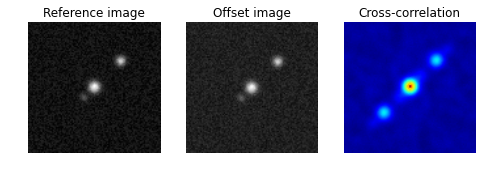

Detected pixel offset (y, x): [ 0.  0.]


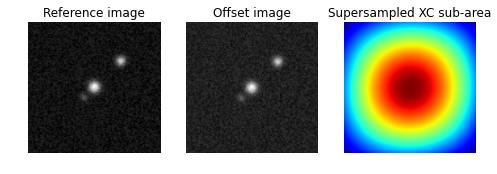

Detected subpixel offset (y, x): [-0.5  0.2]


In [48]:
image = data_2D
shift = (0.5, -0.2)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print("Known offset (y, x): {}".format(shift))

# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x): {}".format(shift))

# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, 100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))

In [50]:
cor = correlate2d(offset_image, image, mode='full', boundary='fill',fillvalue=0)


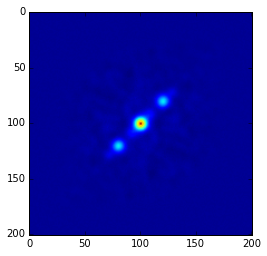

In [55]:
plt.imshow(cor.real)